In [3]:
%cd ./drive/MyDrive/RRCGAN_SMILES_publish/analysis

/content/drive/MyDrive/RRCGAN_SMILES_publish/analysis


In [4]:
!pwd

/content/drive/MyDrive/RRCGAN_SMILES_publish/analysis


In [ ]:
# Strategy 1:
# Generate data after each epoch of training, if less than
# 10% error rate, and is a legit SMILES
# append to the real data
# Otherwise, append to fake data

# ADDING REINFORCEMENT MECHANISM
# Regenerate Normal sampling (define ranges), default: uniform

# IMPORTANT!!!!!!!!!!!!! DO NOT DROP DUPLICATE FOR RESULT .CSV

import warnings
warnings.filterwarnings('ignore')

from progressbar import ProgressBar

import time
import os
import re
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
from numpy import ndarray
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pylab
import pickle

from tensorflow.keras.layers import (Input, Dropout, LSTM, Reshape, LeakyReLU,
                          Concatenate, ReLU, Flatten, Dense, Embedding,
                          BatchNormalization, Activation, SpatialDropout1D,
                          Conv2D, MaxPooling2D, UpSampling2D)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse, binary_crossentropy
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#import np_utils

from tensorflow.keras.utils import  to_categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.lines import Line2D

from progressbar import ProgressBar
import seaborn as sns

from sklearn.metrics import r2_score


print ("!!!!!!!!! we are just before importing rdkit!!!!!")
! pip install rdkit-pypi
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from rdkit import Chem
print ("!!!!!!!!!!!!!!!!!!!!!we are after importing rdkit!!!!!!!!!!!!!!!!!!")

from scipy.stats import truncnorm
from sklearn.decomposition import PCA

import matplotlib.ticker as tk

import ntpath
import re

from sklearn.manifold import TSNE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

from matplotlib.colors import ListedColormap
from matplotlib import rc, rcParams

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(12345)
#gpu_options = tf.GPUOptions(per_prociess_gpu_memory_fraction=0.3667)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, gpu_options=gpu_options)
#tf.set_random_seed(1234)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

!!!!!!!!! we are just before importing rdkit!!!!!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 1.3 MB/s 
!!!!!!!!!!!!!!!!!!!!!we are after importing rdkit!!!!!!!!!!!!!!!!!!


In [ ]:
""" reading and preprocessing data"""
with open('./../data/trainingsets/60000_train_regular_qm9/image_train.pickle', 'rb') as f:
    X_smiles_train, SMILES_train, X_atoms_train, X_bonds_train, y_train = pickle.load(f)

with open('./../data/trainingsets/60000_train_regular_qm9/image_test.pickle', 'rb') as f:
    X_smiles_val, SMILES_val, X_atoms_val, X_bonds_val, y_val = pickle.load(f)

with open('./../data/trainingsets/60000_train_regular_qm9/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

tokenizer[0] = ' '

# Subsampling has been done in the data preprocesses
print ('X_smiles_train shape: ', X_smiles_train.shape)
print ('X_smiles_test shape: ', X_smiles_val.shape)
#print ('last SMILES train: ', SMILES_train[-1])

# Outlier removal 1.5*IQR rule
IQR = - np.quantile(y_train, 0.25) + np.quantile(y_train, 0.75)
lower_bound, upper_bound = np.quantile(y_train, 0.25) - 1.5 * IQR, np.quantile(y_train, 0.75) + 1.5 * IQR
idx = np.where((y_train >= lower_bound) & (y_train <= upper_bound))

y_train = y_train[idx]
X_smiles_train = X_smiles_train[idx]
X_atoms_train = X_atoms_train[idx]
X_bonds_train = X_bonds_train[idx]
# print the first sample
print ('last Cv:', y_train[-1])
print ('last X_smiles_train: ', X_smiles_train[-1])
print ('last X atom: ', X_atoms_train[-1])
print ('last X bond: ', X_bonds_train[-1])

# Outlier removal
IQR = - np.quantile(y_val, 0.25) + np.quantile(y_val, 0.75)
lower_bound, upper_bound = np.quantile(y_val, 0.25) - 1.5 * IQR, np.quantile(y_val, 0.75) + 1.5 * IQR
idx = np.where((y_val >= lower_bound) & (y_val <= upper_bound))

y_val = y_val[idx]
X_smiles_val = X_smiles_val[idx]
X_atoms_val = X_atoms_val[idx]
X_bonds_val = X_bonds_val[idx]

# subsampling
idx = np.random.choice(len(y_train), int(len(y_train) * 0.016), replace = False)
y_train = y_train[idx]
X_smiles_train = X_smiles_train[idx]
X_atoms_train = X_atoms_train[idx]
X_bonds_train = X_bonds_train[idx]


# normalize the bond and aotm matrices:
def norm(X: ndarray) -> ndarray:
    X = np.where(X == 0, -1.0, 1.0)
    return X

X_atoms_train, X_bonds_train = (norm(X_atoms_train),
                                norm(X_bonds_train))
X_atoms_val, X_bonds_val = (norm(X_atoms_val),
                            norm(X_bonds_val))

def y_norm(y: ndarray) -> ndarray:
    scaler_min = np.min(y)
    scaler_max = np.max(y)

    y = (y - scaler_min) / (scaler_max - scaler_min)

    return y, scaler_min, scaler_max

s_min1 = np.min (y_train)
s_max1 = np.max (y_train)

s_min2 = np.min(y_val)
s_max2 = np.max(y_val)
s_min = min(s_min1, s_min2)
s_max = max(s_max1, s_max2)

# should be consistant with your trained models (Autoencoder, Regressor)
s_min_dataset, s_max_dataset = 20.939, 42.237
s_min_norm, s_max_norm = 20.939, 42.237

# normalize the property
y_val   = (y_val -   s_min_norm) / (s_max_norm - s_min_norm)
y_train = (y_train - s_min_norm) / (s_max_norm - s_min_norm)
print ("min and max dataset and val normalized", s_min, s_max, np.min(y_val), np.max(y_val))
print ("min and max dataset and train normalized", s_min, s_max, np.min(y_train), np.max(y_train))
print ("min and max used for normalization: ", s_min_norm, s_max_norm)

""" Training RCGAN """
encoder = load_model('./../data/nns_9HA_noemb_6b6/encoder_newencinp.h5')
decoder = load_model('./../data/nns_9HA_noemb_6b6/decoder_newencinp.h5')
regressor = load_model    ('./../data/nns_9HA_noemb_6b6/regressor.h5')
regressor_top = load_model('./../data/nns_9HA_noemb_6b6/regressor_top.h5')
generator = load_model    ('./../data/nns_9HA_noemb_6b6/generator_new.h5')
discriminator= load_model ('./../data/nns_9HA_noemb_6b6/discriminator_new.h5') 

X_smiles_train shape:  (64264, 35, 23, 1)
X_smiles_test shape:  (9371, 35, 23, 1)
last Cv: 31.52
last X_smiles_train:  [[[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [

N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[33.53643542]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  0% (1 of 150) |                        | Elapsed Time: 0:00:03 ETA:   0:09:41

all gen smiels shape (100,)
gen_errors shape (100,)
[33.41818376]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  1% (2 of 150) |                        | Elapsed Time: 0:00:05 ETA:   0:06:18

all gen smiels shape (100,)
gen_errors shape (100,)
[40.49244699]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  2% (3 of 150) |                        | Elapsed Time: 0:00:06 ETA:   0:03:02

all gen smiels shape (100,)
gen_errors shape (100,)
[21.4454775]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  2% (4 of 150) |                        | Elapsed Time: 0:00:07 ETA:   0:03:05

all gen smiels shape (100,)
gen_errors shape (100,)
[26.39889911]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  3% (5 of 150) |                        | Elapsed Time: 0:00:09 ETA:   0:03:10

all gen smiels shape (100,)
gen_errors shape (100,)
[23.46758522]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  4% (6 of 150) |                        | Elapsed Time: 0:00:10 ETA:   0:03:11

all gen smiels shape (100,)
gen_errors shape (100,)
[31.2146389]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  4% (7 of 150) |#                       | Elapsed Time: 0:00:11 ETA:   0:03:06

all gen smiels shape (100,)
gen_errors shape (100,)
[30.50750933]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  5% (8 of 150) |#                       | Elapsed Time: 0:00:13 ETA:   0:03:23

all gen smiels shape (100,)
gen_errors shape (100,)
[35.50064879]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  6% (9 of 150) |#                       | Elapsed Time: 0:00:16 ETA:   0:07:08

all gen smiels shape (100,)
gen_errors shape (100,)
[27.9894465]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  6% (10 of 150) |#                      | Elapsed Time: 0:00:18 ETA:   0:06:05

all gen smiels shape (100,)
gen_errors shape (100,)
[29.14870456]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  7% (11 of 150) |#                      | Elapsed Time: 0:00:21 ETA:   0:06:07

all gen smiels shape (100,)
gen_errors shape (100,)
[21.13308559]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  8% (12 of 150) |#                      | Elapsed Time: 0:00:24 ETA:   0:07:09

all gen smiels shape (100,)
gen_errors shape (100,)
[26.43861173]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  8% (13 of 150) |#                      | Elapsed Time: 0:00:27 ETA:   0:06:35

all gen smiels shape (100,)
gen_errors shape (100,)
[39.2042991]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


  9% (14 of 150) |##                     | Elapsed Time: 0:00:28 ETA:   0:04:50

all gen smiels shape (100,)
gen_errors shape (100,)
[26.47664314]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 10% (15 of 150) |##                     | Elapsed Time: 0:00:30 ETA:   0:02:59

all gen smiels shape (100,)
gen_errors shape (100,)
[28.44451672]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 10% (16 of 150) |##                     | Elapsed Time: 0:00:31 ETA:   0:02:51

all gen smiels shape (100,)
gen_errors shape (100,)
[39.70407536]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 11% (17 of 150) |##                     | Elapsed Time: 0:00:32 ETA:   0:02:51

all gen smiels shape (100,)
gen_errors shape (100,)
[40.22446056]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 12% (18 of 150) |##                     | Elapsed Time: 0:00:34 ETA:   0:02:51

all gen smiels shape (100,)
gen_errors shape (100,)
[37.65486811]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 12% (19 of 150) |##                     | Elapsed Time: 0:00:35 ETA:   0:02:49

all gen smiels shape (100,)
gen_errors shape (100,)
[22.61782042]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 13% (20 of 150) |###                    | Elapsed Time: 0:00:36 ETA:   0:02:49

all gen smiels shape (100,)
gen_errors shape (100,)
[32.52297216]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 14% (21 of 150) |###                    | Elapsed Time: 0:00:37 ETA:   0:02:45

all gen smiels shape (100,)
gen_errors shape (100,)
[39.20803653]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 14% (22 of 150) |###                    | Elapsed Time: 0:00:39 ETA:   0:02:40

all gen smiels shape (100,)
gen_errors shape (100,)
[40.16104584]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 15% (23 of 150) |###                    | Elapsed Time: 0:00:40 ETA:   0:02:42

all gen smiels shape (100,)
gen_errors shape (100,)
[31.7859381]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 16% (24 of 150) |###                    | Elapsed Time: 0:00:41 ETA:   0:02:42

all gen smiels shape (100,)
gen_errors shape (100,)
[29.04522676]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 16% (25 of 150) |###                    | Elapsed Time: 0:00:42 ETA:   0:02:41

all gen smiels shape (100,)
gen_errors shape (100,)
[39.53530709]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 17% (26 of 150) |###                    | Elapsed Time: 0:00:44 ETA:   0:02:43

all gen smiels shape (100,)
gen_errors shape (100,)
[32.39021873]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 18% (27 of 150) |####                   | Elapsed Time: 0:00:45 ETA:   0:02:42

all gen smiels shape (100,)
gen_errors shape (100,)
[23.87611383]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 18% (28 of 150) |####                   | Elapsed Time: 0:00:46 ETA:   0:02:36

all gen smiels shape (100,)
gen_errors shape (100,)
[29.52667422]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 19% (29 of 150) |####                   | Elapsed Time: 0:00:48 ETA:   0:02:36

all gen smiels shape (100,)
gen_errors shape (100,)
[24.88811376]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 20% (30 of 150) |####                   | Elapsed Time: 0:00:49 ETA:   0:02:43

all gen smiels shape (100,)
gen_errors shape (100,)
[24.02721861]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 20% (31 of 150) |####                   | Elapsed Time: 0:00:50 ETA:   0:02:40

all gen smiels shape (100,)
gen_errors shape (100,)
[24.18298579]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 21% (32 of 150) |####                   | Elapsed Time: 0:00:52 ETA:   0:02:30

all gen smiels shape (100,)
gen_errors shape (100,)
[32.74512424]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 22% (33 of 150) |#####                  | Elapsed Time: 0:00:53 ETA:   0:02:36

all gen smiels shape (100,)
gen_errors shape (100,)
[32.26169731]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 22% (34 of 150) |#####                  | Elapsed Time: 0:00:54 ETA:   0:02:34

all gen smiels shape (100,)
gen_errors shape (100,)
[37.97128365]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 23% (35 of 150) |#####                  | Elapsed Time: 0:00:56 ETA:   0:02:31

all gen smiels shape (100,)
gen_errors shape (100,)
[38.73521932]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 24% (36 of 150) |#####                  | Elapsed Time: 0:00:57 ETA:   0:02:37

all gen smiels shape (100,)
gen_errors shape (100,)
[40.72605475]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 24% (37 of 150) |#####                  | Elapsed Time: 0:00:58 ETA:   0:02:33

all gen smiels shape (100,)
gen_errors shape (100,)
[24.30680079]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 25% (38 of 150) |#####                  | Elapsed Time: 0:01:00 ETA:   0:02:24

all gen smiels shape (100,)
gen_errors shape (100,)
[23.04861812]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 26% (39 of 150) |#####                  | Elapsed Time: 0:01:01 ETA:   0:02:22

all gen smiels shape (100,)
gen_errors shape (100,)
[36.60092141]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 26% (40 of 150) |######                 | Elapsed Time: 0:01:02 ETA:   0:02:18

all gen smiels shape (100,)
gen_errors shape (100,)
[25.97825685]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 27% (41 of 150) |######                 | Elapsed Time: 0:01:03 ETA:   0:02:15

all gen smiels shape (100,)
gen_errors shape (100,)
[30.15617185]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 28% (42 of 150) |######                 | Elapsed Time: 0:01:05 ETA:   0:02:15

all gen smiels shape (100,)
gen_errors shape (100,)
[37.12226182]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 28% (43 of 150) |######                 | Elapsed Time: 0:01:06 ETA:   0:02:16

all gen smiels shape (100,)
gen_errors shape (100,)
[37.65691798]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 29% (44 of 150) |######                 | Elapsed Time: 0:01:07 ETA:   0:02:14

all gen smiels shape (100,)
gen_errors shape (100,)
[35.46022534]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 30% (45 of 150) |######                 | Elapsed Time: 0:01:09 ETA:   0:02:12

all gen smiels shape (100,)
gen_errors shape (100,)
[33.17513325]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 30% (46 of 150) |#######                | Elapsed Time: 0:01:10 ETA:   0:02:11

all gen smiels shape (100,)
gen_errors shape (100,)
[31.39441549]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 31% (47 of 150) |#######                | Elapsed Time: 0:01:11 ETA:   0:02:10

all gen smiels shape (100,)
gen_errors shape (100,)
[28.38642307]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 32% (48 of 150) |#######                | Elapsed Time: 0:01:13 ETA:   0:02:37

all gen smiels shape (100,)
gen_errors shape (100,)
[22.66914685]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 32% (49 of 150) |#######                | Elapsed Time: 0:01:15 ETA:   0:03:04

all gen smiels shape (100,)
gen_errors shape (100,)
[31.83226397]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 33% (50 of 150) |#######                | Elapsed Time: 0:01:16 ETA:   0:02:34

all gen smiels shape (100,)
gen_errors shape (100,)
[23.83579231]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 34% (51 of 150) |#######                | Elapsed Time: 0:01:17 ETA:   0:02:11

all gen smiels shape (100,)
gen_errors shape (100,)
[39.96087334]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 34% (52 of 150) |#######                | Elapsed Time: 0:01:19 ETA:   0:02:08

all gen smiels shape (100,)
gen_errors shape (100,)
[35.22497558]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 35% (53 of 150) |########               | Elapsed Time: 0:01:20 ETA:   0:01:59

all gen smiels shape (100,)
gen_errors shape (100,)
[30.16904958]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 36% (54 of 150) |########               | Elapsed Time: 0:01:21 ETA:   0:01:59

all gen smiels shape (100,)
gen_errors shape (100,)
[38.23318424]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 36% (55 of 150) |########               | Elapsed Time: 0:01:22 ETA:   0:01:57

all gen smiels shape (100,)
gen_errors shape (100,)
[41.07443024]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 37% (56 of 150) |########               | Elapsed Time: 0:01:24 ETA:   0:01:53

all gen smiels shape (100,)
gen_errors shape (100,)
[22.74645626]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 38% (57 of 150) |########               | Elapsed Time: 0:01:25 ETA:   0:01:52

all gen smiels shape (100,)
gen_errors shape (100,)
[21.9742385]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 38% (58 of 150) |########               | Elapsed Time: 0:01:26 ETA:   0:01:51

all gen smiels shape (100,)
gen_errors shape (100,)
[23.19060196]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 39% (59 of 150) |#########              | Elapsed Time: 0:01:27 ETA:   0:01:50

all gen smiels shape (100,)
gen_errors shape (100,)
[38.44865348]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 40% (60 of 150) |#########              | Elapsed Time: 0:01:28 ETA:   0:01:47

all gen smiels shape (100,)
gen_errors shape (100,)
[41.93748064]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 40% (61 of 150) |#########              | Elapsed Time: 0:01:30 ETA:   0:01:50

all gen smiels shape (100,)
gen_errors shape (100,)
[35.63511476]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 41% (62 of 150) |#########              | Elapsed Time: 0:01:31 ETA:   0:01:49

all gen smiels shape (100,)
gen_errors shape (100,)
[36.5575636]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 42% (63 of 150) |#########              | Elapsed Time: 0:01:32 ETA:   0:01:44

all gen smiels shape (100,)
gen_errors shape (100,)
[26.90236996]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 42% (64 of 150) |#########              | Elapsed Time: 0:01:33 ETA:   0:01:42

all gen smiels shape (100,)
gen_errors shape (100,)
[39.88284522]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 43% (65 of 150) |#########              | Elapsed Time: 0:01:34 ETA:   0:01:42

all gen smiels shape (100,)
gen_errors shape (100,)
[32.77070018]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 44% (66 of 150) |##########             | Elapsed Time: 0:01:36 ETA:   0:01:41

all gen smiels shape (100,)
gen_errors shape (100,)
[31.79864428]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 44% (67 of 150) |##########             | Elapsed Time: 0:01:37 ETA:   0:01:39

all gen smiels shape (100,)
gen_errors shape (100,)
[28.24970688]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 45% (68 of 150) |##########             | Elapsed Time: 0:01:38 ETA:   0:01:42

all gen smiels shape (100,)
gen_errors shape (100,)
[38.11665702]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 46% (69 of 150) |##########             | Elapsed Time: 0:01:39 ETA:   0:01:41

all gen smiels shape (100,)
gen_errors shape (100,)
[31.53920773]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 46% (70 of 150) |##########             | Elapsed Time: 0:01:41 ETA:   0:01:36

all gen smiels shape (100,)
gen_errors shape (100,)
[25.05205485]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 47% (71 of 150) |##########             | Elapsed Time: 0:01:42 ETA:   0:01:37

all gen smiels shape (100,)
gen_errors shape (100,)
[33.76050161]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 48% (72 of 150) |###########            | Elapsed Time: 0:01:43 ETA:   0:01:37

all gen smiels shape (100,)
gen_errors shape (100,)
[37.43900565]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 48% (73 of 150) |###########            | Elapsed Time: 0:01:44 ETA:   0:01:34

all gen smiels shape (100,)
gen_errors shape (100,)
[37.39834203]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 49% (74 of 150) |###########            | Elapsed Time: 0:01:46 ETA:   0:01:33

all gen smiels shape (100,)
gen_errors shape (100,)
[34.77959076]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 50% (75 of 150) |###########            | Elapsed Time: 0:01:47 ETA:   0:01:33

all gen smiels shape (100,)
gen_errors shape (100,)
[34.24955863]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 50% (76 of 150) |###########            | Elapsed Time: 0:01:48 ETA:   0:01:39

all gen smiels shape (100,)
gen_errors shape (100,)
[36.51462638]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 51% (77 of 150) |###########            | Elapsed Time: 0:01:49 ETA:   0:01:37

all gen smiels shape (100,)
gen_errors shape (100,)
[31.51673111]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 52% (78 of 150) |###########            | Elapsed Time: 0:01:51 ETA:   0:01:29

all gen smiels shape (100,)
gen_errors shape (100,)
[37.6114412]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 52% (79 of 150) |############           | Elapsed Time: 0:01:52 ETA:   0:01:28

all gen smiels shape (100,)
gen_errors shape (100,)
[35.690784]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 53% (80 of 150) |############           | Elapsed Time: 0:01:53 ETA:   0:01:32

all gen smiels shape (100,)
gen_errors shape (100,)
[30.36451498]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 54% (81 of 150) |############           | Elapsed Time: 0:01:55 ETA:   0:01:31

all gen smiels shape (100,)
gen_errors shape (100,)
[23.46099787]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 54% (82 of 150) |############           | Elapsed Time: 0:01:56 ETA:   0:01:25

all gen smiels shape (100,)
gen_errors shape (100,)
[41.54418416]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 55% (83 of 150) |############           | Elapsed Time: 0:01:57 ETA:   0:01:24

all gen smiels shape (100,)
gen_errors shape (100,)
[32.68858957]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 56% (84 of 150) |############           | Elapsed Time: 0:01:58 ETA:   0:01:24

all gen smiels shape (100,)
gen_errors shape (100,)
[26.6854333]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 56% (85 of 150) |#############          | Elapsed Time: 0:02:00 ETA:   0:01:22

all gen smiels shape (100,)
gen_errors shape (100,)
[40.09266295]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 57% (86 of 150) |#############          | Elapsed Time: 0:02:01 ETA:   0:01:20

all gen smiels shape (100,)
gen_errors shape (100,)
[39.59744569]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 57% (87 of 150) |#############          | Elapsed Time: 0:02:02 ETA:   0:01:19

all gen smiels shape (100,)
gen_errors shape (100,)
[23.55687196]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 58% (88 of 150) |#############          | Elapsed Time: 0:02:04 ETA:   0:01:28

all gen smiels shape (100,)
gen_errors shape (100,)
[37.80711936]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 59% (89 of 150) |#############          | Elapsed Time: 0:02:05 ETA:   0:01:26

all gen smiels shape (100,)
gen_errors shape (100,)
[33.64733732]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 60% (90 of 150) |#############          | Elapsed Time: 0:02:06 ETA:   0:01:14

all gen smiels shape (100,)
gen_errors shape (100,)
[36.99460751]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 60% (91 of 150) |#############          | Elapsed Time: 0:02:08 ETA:   0:01:13

all gen smiels shape (100,)
gen_errors shape (100,)
[21.41271055]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 61% (92 of 150) |##############         | Elapsed Time: 0:02:09 ETA:   0:01:13

all gen smiels shape (100,)
gen_errors shape (100,)
[33.16371129]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 62% (93 of 150) |##############         | Elapsed Time: 0:02:10 ETA:   0:01:12

all gen smiels shape (100,)
gen_errors shape (100,)
[37.98632412]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 62% (94 of 150) |##############         | Elapsed Time: 0:02:11 ETA:   0:01:11

all gen smiels shape (100,)
gen_errors shape (100,)
[32.543767]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 63% (95 of 150) |##############         | Elapsed Time: 0:02:13 ETA:   0:01:08

all gen smiels shape (100,)
gen_errors shape (100,)
[39.84494662]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 64% (96 of 150) |##############         | Elapsed Time: 0:02:14 ETA:   0:01:10

all gen smiels shape (100,)
gen_errors shape (100,)
[40.55074703]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 64% (97 of 150) |##############         | Elapsed Time: 0:02:15 ETA:   0:01:10

all gen smiels shape (100,)
gen_errors shape (100,)
[31.19846838]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 65% (98 of 150) |###############        | Elapsed Time: 0:02:16 ETA:   0:01:05

all gen smiels shape (100,)
gen_errors shape (100,)
[29.37832323]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 66% (99 of 150) |###############        | Elapsed Time: 0:02:18 ETA:   0:01:03

all gen smiels shape (100,)
gen_errors shape (100,)
[23.91898102]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 66% (100 of 150) |##############        | Elapsed Time: 0:02:19 ETA:   0:01:02

all gen smiels shape (100,)
gen_errors shape (100,)
[26.73327278]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 67% (101 of 150) |##############        | Elapsed Time: 0:02:20 ETA:   0:01:01

all gen smiels shape (100,)
gen_errors shape (100,)
[29.61595066]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 68% (102 of 150) |##############        | Elapsed Time: 0:02:21 ETA:   0:01:00

all gen smiels shape (100,)
gen_errors shape (100,)
[37.63510037]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 68% (103 of 150) |###############       | Elapsed Time: 0:02:23 ETA:   0:01:02

all gen smiels shape (100,)
gen_errors shape (100,)
[33.93708773]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 69% (104 of 150) |###############       | Elapsed Time: 0:02:24 ETA:   0:01:01

all gen smiels shape (100,)
gen_errors shape (100,)
[28.21791825]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 70% (105 of 150) |###############       | Elapsed Time: 0:02:25 ETA:   0:00:56

all gen smiels shape (100,)
gen_errors shape (100,)
[24.77186646]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 70% (106 of 150) |###############       | Elapsed Time: 0:02:27 ETA:   0:00:55

all gen smiels shape (100,)
gen_errors shape (100,)
[25.92030758]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 71% (107 of 150) |###############       | Elapsed Time: 0:02:28 ETA:   0:00:53

all gen smiels shape (100,)
gen_errors shape (100,)
[21.81510969]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 72% (108 of 150) |###############       | Elapsed Time: 0:02:29 ETA:   0:00:52

all gen smiels shape (100,)
gen_errors shape (100,)
[41.16835771]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 72% (109 of 150) |###############       | Elapsed Time: 0:02:31 ETA:   0:00:55

all gen smiels shape (100,)
gen_errors shape (100,)
[39.70098706]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 73% (110 of 150) |################      | Elapsed Time: 0:02:32 ETA:   0:00:58

all gen smiels shape (100,)
gen_errors shape (100,)
[29.95206815]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 74% (111 of 150) |################      | Elapsed Time: 0:02:33 ETA:   0:00:56

all gen smiels shape (100,)
gen_errors shape (100,)
[25.45068213]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 74% (112 of 150) |################      | Elapsed Time: 0:02:36 ETA:   0:01:27

all gen smiels shape (100,)
gen_errors shape (100,)
[34.64994663]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 75% (113 of 150) |################      | Elapsed Time: 0:02:37 ETA:   0:01:12

all gen smiels shape (100,)
gen_errors shape (100,)
[33.2129911]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 76% (114 of 150) |################      | Elapsed Time: 0:02:39 ETA:   0:00:51

all gen smiels shape (100,)
gen_errors shape (100,)
[27.77996111]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 76% (115 of 150) |################      | Elapsed Time: 0:02:40 ETA:   0:00:44

all gen smiels shape (100,)
gen_errors shape (100,)
[26.79271441]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 77% (116 of 150) |#################     | Elapsed Time: 0:02:42 ETA:   0:00:48

all gen smiels shape (100,)
gen_errors shape (100,)
[38.25342187]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 78% (117 of 150) |#################     | Elapsed Time: 0:02:43 ETA:   0:00:46

all gen smiels shape (100,)
gen_errors shape (100,)
[33.06499392]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 78% (118 of 150) |#################     | Elapsed Time: 0:02:44 ETA:   0:00:39

all gen smiels shape (100,)
gen_errors shape (100,)
[35.77830848]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 79% (119 of 150) |#################     | Elapsed Time: 0:02:45 ETA:   0:00:38

all gen smiels shape (100,)
gen_errors shape (100,)
[27.82024613]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 80% (120 of 150) |#################     | Elapsed Time: 0:02:46 ETA:   0:00:37

all gen smiels shape (100,)
gen_errors shape (100,)
[26.24169859]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 80% (121 of 150) |#################     | Elapsed Time: 0:02:48 ETA:   0:00:36

all gen smiels shape (100,)
gen_errors shape (100,)
[28.25971698]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 81% (122 of 150) |#################     | Elapsed Time: 0:02:49 ETA:   0:00:34

all gen smiels shape (100,)
gen_errors shape (100,)
[37.59084761]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 82% (123 of 150) |##################    | Elapsed Time: 0:02:50 ETA:   0:00:33

all gen smiels shape (100,)
gen_errors shape (100,)
[29.17174789]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 82% (124 of 150) |##################    | Elapsed Time: 0:02:51 ETA:   0:00:32

all gen smiels shape (100,)
gen_errors shape (100,)
[28.04228617]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 83% (125 of 150) |##################    | Elapsed Time: 0:02:53 ETA:   0:00:30

all gen smiels shape (100,)
gen_errors shape (100,)
[25.70715868]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 84% (126 of 150) |##################    | Elapsed Time: 0:02:54 ETA:   0:00:29

all gen smiels shape (100,)
gen_errors shape (100,)
[30.24822462]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 84% (127 of 150) |##################    | Elapsed Time: 0:02:55 ETA:   0:00:28

all gen smiels shape (100,)
gen_errors shape (100,)
[21.51797784]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 85% (128 of 150) |##################    | Elapsed Time: 0:02:56 ETA:   0:00:27

all gen smiels shape (100,)
gen_errors shape (100,)
[36.0149555]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 86% (129 of 150) |##################    | Elapsed Time: 0:02:58 ETA:   0:00:25

all gen smiels shape (100,)
gen_errors shape (100,)
[28.37655106]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 86% (130 of 150) |###################   | Elapsed Time: 0:02:59 ETA:   0:00:24

all gen smiels shape (100,)
gen_errors shape (100,)
[32.36064697]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 87% (131 of 150) |###################   | Elapsed Time: 0:03:00 ETA:   0:00:23

all gen smiels shape (100,)
gen_errors shape (100,)
[37.88346243]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 88% (132 of 150) |###################   | Elapsed Time: 0:03:01 ETA:   0:00:22

all gen smiels shape (100,)
gen_errors shape (100,)
[40.3149266]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 88% (133 of 150) |###################   | Elapsed Time: 0:03:03 ETA:   0:00:21

all gen smiels shape (100,)
gen_errors shape (100,)
[21.97947788]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 89% (134 of 150) |###################   | Elapsed Time: 0:03:04 ETA:   0:00:19

all gen smiels shape (100,)
gen_errors shape (100,)
[34.8553956]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 90% (135 of 150) |###################   | Elapsed Time: 0:03:05 ETA:   0:00:18

all gen smiels shape (100,)
gen_errors shape (100,)
[22.44189252]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 90% (136 of 150) |###################   | Elapsed Time: 0:03:06 ETA:   0:00:17

all gen smiels shape (100,)
gen_errors shape (100,)
[31.34865454]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 91% (137 of 150) |####################  | Elapsed Time: 0:03:07 ETA:   0:00:15

all gen smiels shape (100,)
gen_errors shape (100,)
[41.19545464]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 92% (138 of 150) |####################  | Elapsed Time: 0:03:09 ETA:   0:00:14

all gen smiels shape (100,)
gen_errors shape (100,)
[33.89847639]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 92% (139 of 150) |####################  | Elapsed Time: 0:03:10 ETA:   0:00:13

all gen smiels shape (100,)
gen_errors shape (100,)
[38.73385732]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 93% (140 of 150) |####################  | Elapsed Time: 0:03:11 ETA:   0:00:12

all gen smiels shape (100,)
gen_errors shape (100,)
[34.13945527]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 94% (141 of 150) |####################  | Elapsed Time: 0:03:12 ETA:   0:00:11

all gen smiels shape (100,)
gen_errors shape (100,)
[20.94587799]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 94% (142 of 150) |####################  | Elapsed Time: 0:03:14 ETA:   0:00:09

all gen smiels shape (100,)
gen_errors shape (100,)
[38.80106326]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 95% (143 of 150) |####################  | Elapsed Time: 0:03:15 ETA:   0:00:08

all gen smiels shape (100,)
gen_errors shape (100,)
[27.72927324]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 96% (144 of 150) |##################### | Elapsed Time: 0:03:16 ETA:   0:00:07

all gen smiels shape (100,)
gen_errors shape (100,)
[31.73240757]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 96% (145 of 150) |##################### | Elapsed Time: 0:03:17 ETA:   0:00:06

all gen smiels shape (100,)
gen_errors shape (100,)
[23.54117571]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 97% (146 of 150) |##################### | Elapsed Time: 0:03:19 ETA:   0:00:04

all gen smiels shape (100,)
gen_errors shape (100,)
[30.48666339]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 98% (147 of 150) |##################### | Elapsed Time: 0:03:20 ETA:   0:00:03

all gen smiels shape (100,)
gen_errors shape (100,)
[28.95185164]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 98% (148 of 150) |##################### | Elapsed Time: 0:03:21 ETA:   0:00:02

all gen smiels shape (100,)
gen_errors shape (100,)
[42.187172]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


 99% (149 of 150) |##################### | Elapsed Time: 0:03:22 ETA:   0:00:01

all gen smiels shape (100,)
gen_errors shape (100,)
[22.07092113]
shape argmax_smiles (100, 35, 1)
shape line 767 [100, 35, 23, 1]


100% (150 of 150) |######################| Elapsed Time: 0:03:24 Time:  0:03:24


all gen smiels shape (100,)
gen_errors shape (100,)


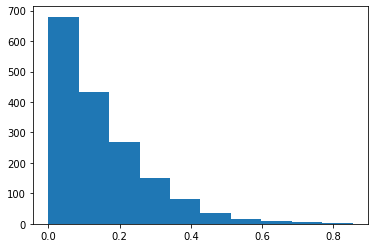

In [ ]:
N = 100
n_sample = 150

gen_error = []
gen_smiles = []
sample_ys = []
preds = []
gen_atoms_embedding = []
gen_bonds_embedding = []

regressor_top.trainable = False
regressor.trainable = False
generator.trainable = False
discriminator.trainable = False

pbar = ProgressBar()
for hc in pbar(range(n_sample)):
    #try:
        # get it back to original of s_min to s_max
        sample_y = np.random.uniform(s_min_dataset, s_max_dataset, size = [1,])
        #X = get_truncated_normal(mean=30, sd=5, low=s_min, upp=s_max)
        #sample_y = X.rvs()
        print (sample_y)
        sample_y = np.round(sample_y, 4)
        sample_y = sample_y * np.ones([N,])
        sample_y_ = (sample_y - s_min_norm) / (s_max_norm - s_min_norm)
        sample_z = np.random.normal(0, 1, size = (N, 128))

        regressor_top.trainable = False
        regressor.trainable = False

        sample_atoms_embedding, sample_bonds_embedding = generator.predict([sample_z, sample_y_])
        dec_embedding = np.concatenate([sample_atoms_embedding, sample_bonds_embedding], axis = -1)

        softmax_smiles = decoder.predict(dec_embedding)[0]
        argmax_smiles = np.argmax(softmax_smiles, axis = 2)
        print ('shape argmax_smiles', argmax_smiles.shape)
        smiles = to_categorical(argmax_smiles, num_classes=23)
        SHAPE = list(smiles.shape) + [1]
        print ('shape line 767', SHAPE)
        smiles = smiles.reshape(SHAPE)

        latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles])
        pred = regressor.predict([latent_encoder_atom, latent_encoder_bond]).reshape([-1])
        pred = pred * (s_max_norm - s_min_norm) + s_min_norm

        gen_errors = np.abs((pred - sample_y) / sample_y).reshape([-1])

        #accurate = np.where(gen_errors <= 0.2)[0]
        #gen_errors = gen_errors[accurate]
        #pred = pred[accurate]

        #sample_y = sample_y[accurate]
        #sample_atoms_embedding = sample_atoms_embedding[accurate]
        #sample_bonds_embedding = sample_bonds_embedding[accurate]

        smiles = decoder.predict(dec_embedding)[0]
        smiles = np.argmax(smiles, axis = 2).reshape(smiles.shape[0], 35)

        generated_smiles = []
        for S in smiles:
            c_smiles = ''
            for s in S:
                c_smiles += tokenizer[s]
            c_smiles = c_smiles.rstrip()
            generated_smiles.append(c_smiles)
        generated_smiles = np.array(generated_smiles)
        #generated_smiles = generated_smiles [accurate]
        all_gen_smiles = []
        idx = []
        for i, smiles in enumerate(generated_smiles):
            all_gen_smiles.append(smiles[:-1])

            if ' ' in smiles[:-1]:
                continue
            #m = Chem.MolFromSmiles(smiles[:-1],sanitize=False)
            m = Chem.MolFromSmiles(smiles[:-1])
            if m is not None:
                idx.append(i)

        idx = np.array(idx)
        all_gen_smiles = np.array(all_gen_smiles)
        print ('all gen smiels shape', all_gen_smiles.shape)
        print ('gen_errors shape', gen_errors.shape)
        gen_smiles.extend(list(all_gen_smiles[idx]))
        gen_error.extend(list(gen_errors[idx]))
        sample_ys.extend(list(sample_y[idx]))
        gen_atoms_embedding.extend(sample_atoms_embedding[idx])
        gen_bonds_embedding.extend(sample_bonds_embedding[idx])

        preds.extend(list(pred[idx]))
    #except:
    #    print('Did not discover SMILES for HC: {}'.format(sample_y))
    #    pass   

 
output = {}

for i, s in enumerate (gen_smiles):

    ss = Chem.MolToSmiles(Chem.MolFromSmiles(s))
    gen_smiles[i] = ss

output['SMILES'] = gen_smiles
output['des_cv'] = sample_ys
output['pred_cv'] = preds
output['Err_pred_des'] = gen_error

plt.close()
plt.hist(gen_error)
plt.savefig("./latent_analysis/gen_error_hist.png")

explained_varice_R2_DFT_des 0.06487176078923917
MAE_DFT_des 4.470834938301813
Fractioned MAE_DFT_des 0.14667697246300698
RMSE_DFT_des 5.594845923045788
Fractioned_RMSE_DFT_des 0.19524756685942826
quantile of train samples:  [26.96780014 28.59459991 29.66239929 30.78440018 31.86800003 32.88080063
 33.83759918 35.12679901 36.87820129]
[33.545 31.492 26.993 ... 27.192 33.622 29.629]
[3. 2. 0. ... 0. 3. 1.]
[2. 4. 2. ... 0. 1. 1.]
[ 0.46004292 -0.9570388  -0.13413726 -0.17919128 -0.29101813  0.68271255
 -0.6027738  -0.8085147   0.6684544  -0.06398934 -0.22595222  0.52039814
 -0.51561767 -0.8196077   0.6918887   0.6718326   0.45265943  0.54979753
 -0.69745743  0.53797543  0.92415696  0.7908978  -0.36568943  0.6487067
  0.40543354 -0.3238359   0.6675568   0.423205    0.04912875  0.37896505
  0.80414844 -0.90218824  0.01018141 -0.52666056 -0.32318884 -0.10845254]
and your test embedding:  [ 0.37978822 -0.9313213   0.8021092   0.4388024   0.290175    0.767671
 -0.48604375 -0.69514024  0.717060

"with open('gen_pickles.pickle', 'wb') as f:\n    pickle.dump(gen_unique_pickles, f)\n"

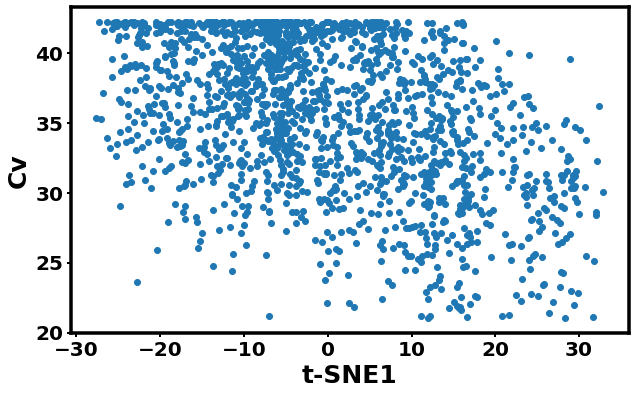

In [ ]:
## Statistics  (# DFT=True value, Des=prediction)

# total # of samples
N = len(gen_error)
# Explained Variance R2 from sklearn.metrics.explained_variance_score
explained_variance_R2_DFT_des = explained_variance_score(output['pred_cv'], output['des_cv'])
print ("explained_varice_R2_DFT_des", explained_variance_R2_DFT_des)

# mean absolute error 
MAE_DFT_des = mean_absolute_error(output['pred_cv'], output['des_cv'])
print ("MAE_DFT_des", MAE_DFT_des)
# Fractioned MAE, more normalized
Fractioned_MAE_DFT_des = 0
for dft, des in zip(output['pred_cv'], output['des_cv']):
    Fractioned_MAE_DFT_des = Fractioned_MAE_DFT_des +  abs(des-dft)/des
Fractioned_MAE_DFT_des = Fractioned_MAE_DFT_des/N
print ("Fractioned MAE_DFT_des", Fractioned_MAE_DFT_des)

# root mean squared error (RMSE), sqrt(sklearn ouputs MSE)
RMSE_DFT_des = mean_squared_error(output['pred_cv'], output['des_cv'])**0.5
print ("RMSE_DFT_des", RMSE_DFT_des)

Fractioned_RMSE_DFT_des = 0
for dft, des in zip(output['pred_cv'], output['des_cv']):
    Fractioned_RMSE_DFT_des = Fractioned_RMSE_DFT_des + ((des-dft)/des)**2
Fractioned_RMSE_DFT_des = (Fractioned_RMSE_DFT_des/N)**0.5
print ("Fractioned_RMSE_DFT_des", Fractioned_RMSE_DFT_des)

output = pd.DataFrame(output)
# do not drop duplicate
output2 = output.drop_duplicates(['SMILES'])
gen_atoms_embedding = np.array(gen_atoms_embedding)
gen_bonds_embedding = np.array(gen_bonds_embedding)


# create classes for heat capacity
y_train = y_train * (s_max_norm - s_min_norm) + s_min_norm

Qs = np.quantile(y_train, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
print ("quantile of train samples: ", Qs)
y_class = y_train
print (y_class) 
"""
# 10 classes
y_class = np.where(y_train <= Qs[0], 0, y_class)
y_class = np.where((y_train > Qs[0]) & (y_train <= Qs[1]), 1, y_class)
y_class = np.where((y_train > Qs[1]) & (y_train <= Qs[2]), 2, y_class)
y_class = np.where((y_train > Qs[2]) & (y_train <= Qs[3]), 3, y_class)
y_class = np.where((y_train > Qs[3]) & (y_train <= Qs[4]), 4, y_class)
y_class = np.where((y_train > Qs[4]) & (y_train <= Qs[5]), 5, y_class)
y_class = np.where((y_train > Qs[5]) & (y_train <= Qs[6]), 6, y_class)
y_class = np.where((y_train > Qs[6]) & (y_train <= Qs[7]), 7, y_class)
y_class = np.where((y_train > Qs[7]) & (y_train <= Qs[8]), 8, y_class)
y_class = np.where(y_train > Qs[8], 9, y_class)
"""
# 5 classes
y_class = np.where(y_train <= Qs[1], 0, y_class)
y_class = np.where((y_train > Qs[1]) & (y_train <= Qs[3]), 1, y_class)
y_class = np.where((y_train > Qs[3]) & (y_train <= Qs[5]), 2, y_class)
y_class = np.where((y_train > Qs[5]) & (y_train <= Qs[7]), 3, y_class)
y_class = np.where(y_train > Qs[7], 4, y_class)

print (y_class)
Qs_gen = np.quantile(preds, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
y_class_val = preds

# 5 classes
y_class_val = np.where(preds <= Qs_gen[1], 0, y_class_val)
y_class_val = np.where((preds > Qs_gen[1]) & (preds <= Qs_gen[3]), 1, y_class_val)
y_class_val = np.where((preds > Qs_gen[3]) & (preds <= Qs_gen[5]), 2, y_class_val)
y_class_val = np.where((preds > Qs_gen[5]) & (preds <= Qs_gen[7]), 3, y_class_val)
y_class_val = np.where(preds > Qs_gen[7], 4, y_class_val)

print (y_class_val)
# ANALYSIS
train_atoms_embedding, train_bonds_embedding, _ = encoder.predict([X_smiles_train]) 

X_atoms_train_ = train_atoms_embedding.reshape([train_atoms_embedding.shape[0], 
                                        6 * 6])
X_bonds_train_ = train_bonds_embedding.reshape([train_bonds_embedding.shape[0], 
                                        6 * 6])

X_atoms_test_ = gen_atoms_embedding.reshape([gen_atoms_embedding.shape[0],
                                      6 * 6])
X_bonds_test_ = gen_bonds_embedding.reshape([gen_bonds_embedding.shape[0], 
                                      6 * 6])

""" PCA """
pca_1 = PCA(n_components = 2)
X_atoms_train = pca_1.fit_transform(X_atoms_train_)
X_atoms_test = pca_1.transform(X_atoms_test_)

pca_2 = PCA(n_components = 2)
X_bonds_train = pca_2.fit_transform(X_bonds_train_)
X_bonds_test = pca_2.transform(X_bonds_test_)

# PCA1 vs. PCA2 Atoms gen and train
plt.close()
fig, ax = plt.subplots(figsize =(8, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
plt.scatter(X_atoms_train[:,0], X_atoms_train[:,1], alpha = 0.2, c = 'blue')
ax.tick_params(width=2, length=4)
plt.xlabel('PC1', fontsize=25, weight='bold')
plt.ylabel('PC2', fontsize=25, weight='bold')
#plt.close()
plt.scatter(X_atoms_test[:,0], X_atoms_test[:,1], alpha = 0.2, c = 'red')
plt.savefig("./latent_analysis/Mix_train_gen_atom_dist_{}Sam.png".format(len(y_train)), bbox_inches='tight', dpi=300)
####

# PCA1 vs. PCA2 Bonds gen and train
plt.close()
fig, ax = plt.subplots(figsize =(8, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
plt.scatter(X_bonds_train[:,0], X_bonds_train[:,1], alpha = 0.2, c = 'blue')
ax.tick_params(width=2, length=4)
plt.xlabel('PC1', fontsize=25, weight='bold')
plt.ylabel('PC2', fontsize=25, weight='bold')
#plt.close()
plt.scatter(X_bonds_test[:,0], X_bonds_test[:,1], alpha = 0.2, c = 'red')
plt.savefig("./latent_analysis/Mix_train_gen_bonds_dist_{}Sam.png".format(len(preds)), bbox_inches='tight', dpi=300)

""" concat. latent vectors """
X_Concat_train =  np.concatenate ([X_bonds_train_, X_atoms_train_], axis=1)
X_Concat_test  =  np.concatenate ([X_bonds_test_, X_atoms_test_], axis=1)
pca_2 = PCA(n_components = 2)
X_concat_train_pca = pca_2.fit_transform(X_Concat_train)
X_concat_test_pca = pca_2.transform(X_Concat_test)

# PCA1 vs. cv gen. and train
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
preds_rev = [max(preds)-i for i in preds]
plt.scatter(X_concat_test_pca[:, 0], preds)
#plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('PC1', fontsize=25, fontweight='bold')
plt.ylabel('Cv', fontsize=25, fontweight='bold')
plt.scatter(X_concat_train_pca[:, 0], y_train)
plt.savefig("./latent_analysis/genvstrain_Concat_pc1vscv.png", bbox_inches='tight', dpi=300)

# PCA2 vs. cv gen and train
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
preds_rev = [max(preds)-i for i in preds]
plt.scatter(X_concat_test_pca[:, 1], preds, c='red')
#plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('PC2', fontsize=25, fontweight='bold')
plt.ylabel('Cv', fontsize=25, fontweight='bold')
plt.scatter(X_concat_train_pca[:, 1], y_train, c='blue')
plt.savefig("./latent_analysis/genvstrain_Concat_pc2vscv.png", bbox_inches='tight', dpi=300)

# PCA1 vs. PCA2 gen and train
plt.close()
fig, ax = plt.subplots(figsize =(8, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
plt.scatter(X_concat_train_pca[:, 0], X_concat_train_pca[:, 1], alpha=0.2, c='blue')
ax.tick_params(width=2, length=4)
plt.xlabel('PC1', fontsize=25, weight='bold')
plt.ylabel('PC2', fontsize=25, weight='bold')
#plt.close()
plt.scatter(X_concat_test_pca[:, 0], X_concat_test_pca[:, 1], alpha=0.2, c='red')
plt.savefig("./latent_analysis/genvstrain_concat_pc1vspc2.png".format(len(preds)), bbox_inches='tight', dpi=300)

# t-SNE
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=36):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 500
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


colors = ['navy', 'mediumblue','blue', 'cornflowerblue', 'lightsteelblue', 'lavender',
          'salmon', 'lightcoral', 'orangered', 'darkred']
colors = ['darkblue', 'lightsteelblue',
          'salmon', 'orangered', 'darkred']
"""
group_names = np.array(["Cv<{}".format(np.round(Qs[0])), 
                            "{}<Cv<{}".format(np.round(Qs[0]), np.round(Qs[1])),
                            "{}<Cv<{}".format(np.round(Qs[1]), np.round(Qs[2])),
                            "{}<Cv<{}".format(np.round(Qs[2]), np.round(Qs[3])),
                            "{}<Cv<{}".format(np.round(Qs[3]), np.round(Qs[4])),
                            "{}<Cv<{}".format(np.round(Qs[4]), np.round(Qs[5])),
                            "{}<Cv<{}".format(np.round(Qs[5]), np.round(Qs[6])),
                            "{}<Cv<{}".format(np.round(Qs[6]), np.round(Qs[7])),
                            "{}<Cv<{}".format(np.round(Qs[7]), np.round(Qs[8])),
                            "{}<Cv".format(np.round(Qs[8]))])

group_names_gen = np.array(["Cv<{}".format(np.round(Qs_gen[0])), 
                            "{}<Cv<{}".format(np.round(Qs_gen[0]), np.round(Qs_gen[1])),
                            "{}<Cv<{}".format(np.round(Qs_gen[1]), np.round(Qs_gen[2])),
                            "{}<Cv<{}".format(np.round(Qs_gen[2]), np.round(Qs_gen[3])),
                            "{}<Cv<{}".format(np.round(Qs_gen[3]), np.round(Qs_gen[4])),
                            "{}<Cv<{}".format(np.round(Qs_gen[4]), np.round(Qs_gen[5])),
                            "{}<Cv<{}".format(np.round(Qs_gen[5]), np.round(Qs_gen[6])),
                            "{}<Cv<{}".format(np.round(Qs_gen[6]), np.round(Qs_gen[7])),
                            "{}<Cv<{}".format(np.round(Qs_gen[7]), np.round(Qs_gen[8])),
                            "{}<Cv".format(np.round(Qs_gen[8]))])
"""
group_names = np.array(["Cv<{}".format(np.round(Qs[1])), 
                            "{}<Cv<{}".format(np.round(Qs[1]), np.round(Qs[3])),
                            "{}<Cv<{}".format(np.round(Qs[3]), np.round(Qs[5])),
                            "{}<Cv<{}".format(np.round(Qs[5]), np.round(Qs[7])),
                            "{}<Cv".format(np.round(Qs[7]))])

group_names_gen = np.array(["Cv<{}".format(np.round(Qs_gen[1])), 
                            "{}<Cv<{}".format(np.round(Qs_gen[1]), np.round(Qs_gen[3])),
                            "{}<Cv<{}".format(np.round(Qs_gen[3]), np.round(Qs_gen[5])),
                            "{}<Cv<{}".format(np.round(Qs_gen[5]), np.round(Qs_gen[7])),
                            "{}<Cv".format(np.round(Qs_gen[7]))])

target_ids = range(0,5)

print (X_atoms_train_ [0])
print ("and your test embedding: ", X_atoms_test_[0])

print ("bonds")
print (X_bonds_train_ [0])
print ("and your bonds embedding: ", X_bonds_test_[0])

""" t-SNE Atoms Distribution """
# tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0)
X_atoms_train_tsne = tsne(X_atoms_train_, no_dims=2, initial_dims=36, perplexity=50.0)
X_atoms_test_tsne = tsne (X_atoms_test_, no_dims=2, initial_dims=36, perplexity=30.0)

# tsne1 vs. tsne2 atoms train
plt.close()
rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names):
    plt.scatter(X_atoms_train_tsne[y_class == i, 0], 
                X_atoms_train_tsne[y_class == i, 1], 
                c=c, label=label)
plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('t-SNE2', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/train_atom_dist_tsne.png", bbox_inches='tight', dpi=300)

# tsne1 vs. tsne2 atoms gen.
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names_gen):
    plt.scatter(X_atoms_test_tsne[y_class_val == i, 0], 
                X_atoms_test_tsne[y_class_val == i, 1], 
                c=c, label=label)
plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('t-SNE2', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/gen_atom_dist_tsne.png", bbox_inches='tight', dpi=300)

""" t-SNE bonds distribution """
X_bonds_train_tsne = tsne(X_bonds_train_, 2, 36, 50.0)
X_bonds_test_tsne = tsne (X_bonds_test_, 2, 36, 50.0)

# tsne1 vs. tsne2 bond train
plt.close()
fig, ax = plt.subplots(figsize =(10, 5))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names):
    plt.scatter(X_bonds_train_tsne[y_class == i, 0], 
                X_bonds_train_tsne[y_class == i, 1], 
                alpha = 0.5, c=c, label=label)
plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('t_SNE2', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/train_bonds_dist_tsne.png", bbox_inches='tight', dpi=300)

# tsne1 vs. cv bond train
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
plt.scatter(X_bonds_train_tsne[:, 0], y_train)
#plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('Cv', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/train_bonds_tsne1vscv.png", bbox_inches='tight', dpi=300)

# tsne2 vs. cv bond train
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
preds_rev = [max(preds)-i for i in preds]
plt.scatter(X_bonds_train_tsne[:, 1], y_train)
#plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE2', fontsize=25, fontweight='bold')
plt.ylabel('Cv', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/train_bonds_tsne2vscv.png", bbox_inches='tight', dpi=300)

# tsne1 vs. tsne2 gen.
plt.close()
fig, ax = plt.subplots(figsize =(10, 5))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names_gen):
    plt.scatter(X_bonds_test_tsne[y_class_val == i, 0], 
                X_bonds_test_tsne[y_class_val == i, 1], 
                alpha = 0.5, c=c, label=label)
plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('t_SNE2', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/gen_bonds_dist_tsne.png", bbox_inches='tight', dpi=300)

# t-sne1 vs. cv bond gen.
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
preds_rev = [max(preds)-i for i in preds]
plt.scatter(X_bonds_test_tsne[:, 0], preds, c=preds_rev)
#plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('Cv', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/gen_bonds_tsne1vscv_colored.png", bbox_inches='tight', dpi=300)

# t-sne2 vs. cv bond gen.
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
preds_rev = [max(preds)-i for i in preds]
plt.scatter(X_bonds_test_tsne[:, 1], preds, c=preds_rev)
#plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('Cv', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/gen_bonds_tsne2vscv_colored.png", bbox_inches='tight', dpi=300)

"""tsne of combined atom and bond matrices"""
X_Concat_train_tsne = tsne(X_Concat_train, 6, 72, 50.0)
X_Concat_test_tsne = tsne (X_Concat_test, 6, 72, 50.0)

# tsne1 vs. tsne 2 train
plt.close()
fig, ax = plt.subplots(figsize=(10, 5))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names):
    plt.scatter(X_Concat_train_tsne[y_class == i, 0], 
                X_Concat_train_tsne[y_class == i, 1], 
                alpha=0.5, c=c, label=label)
plt.legend(fontsize=12, bbox_to_anchor=(0, 2))
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('t_SNE2', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/train_concat_dist_tsne.png", bbox_inches='tight', dpi=300)

# tsne1 vs. cv train
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
plt.scatter(X_Concat_train_tsne[:, 0], y_train)
#plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('Cv', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/train_concat_tsne1vscv.png", bbox_inches='tight', dpi=300)

# tsne2 vs. cv train
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
preds_rev = [max(y_train)-i for i in y_train]
plt.scatter(X_Concat_train_tsne[:, 1], y_train)
#plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE2', fontsize=25, fontweight='bold')
plt.ylabel('Cv', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/train_Concat_tsne2vscv.png", bbox_inches='tight', dpi=300)

# tsne1 vs. tsne2 gen.
plt.close()
fig, ax = plt.subplots(figsize =(10, 5))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names_gen):
    plt.scatter(X_Concat_test_tsne[y_class_val == i, 0], 
                X_Concat_test_tsne[y_class_val == i, 1], 
                alpha = 0.5, c=c, label=label)
plt.legend(fontsize=12, bbox_to_anchor=(0, 2))
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('t_SNE2', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/gen_Concat_dist_tsne.png", bbox_inches='tight', dpi=300)

# tsne1 vs. cv gen.
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
preds_rev = [max(preds)-i for i in preds]
plt.scatter(X_Concat_test_tsne[:, 0], preds)
#plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('Cv', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/gen_Concat_tsne1vscv.png", bbox_inches='tight', dpi=300)

# tsne2 vs. cv gen.
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
preds_rev = [max(preds)-i for i in preds]
plt.scatter(X_Concat_test_tsne[:, 1], preds)
#plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('Cv', fontsize=25, fontweight='bold')
plt.savefig("./latent_analysis/gen_Concat_tsne2vscv.png", bbox_inches='tight', dpi=300)

"""
output.reset_index(drop=True, inplace=True)
output2.reset_index(drop=True, inplace=True)
output.to_csv ('./../experiments/regular_9HA_6b6latent/Regular_noscreen2.csv', index = False)
output2.to_csv('./../experiments/regular_9HA_6b6latent/Regular_NODUP_noscreen2.csv', index = False)
"""with open('gen_pickles.pickle', 'wb') as f:
    pickle.dump(gen_unique_pickles, f)
"""
"""